# False Discoveries Occur Early on the Lasso Path
by Weijie Su, Malgorzata Bogdan, Emmanuel Candes
(arXiv link: https://arxiv.org/abs/1511.01957)

This document has been developed with the aim of reproducing the authors' results, but also to extend them to the framework of the positive Lasso.

This work was carried out as part of a project for the Master course Theoretical guidelines for high dimensional data analysis, taught by Christophe Giraud, professor at the Université Paris-Sud.

In no way do the authors of this notebook claim any theoretical or empirical discovery of the results presented.

Authors: Clotilde Miura and Cédric Allain

In [1]:
import numpy as np
import pandas as pd
import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='ticks')
sns.set(color_codes=True)
%matplotlib inline

from itertools import cycle
from sklearn.linear_model import lasso_path, lars_path

import warnings
warnings.filterwarnings("ignore")

## Data generation

In [2]:
# Data generation
def generate_data(p=1000, delta=1, epsilon=0.2, M=4,
                  sigma_data='1/n', sigma_noise=1, verbose=0):
    """Generate data matrix X, true coefficients and true responses y
    
    Parameters:
        p: number of variables
        delta: ratio of p/n
        epsilon: proportion of non nul coeficients
                (if set > 1, then represents the number of non nul coefficients)
        M: value taken by the non nul coeficients
        sigma_data: noise used to generate the data, either a double, or '1/n'
        sigma_noise: standard deviation for the noise
        verbose: interger, if not null, print some informations
    
    Outputs:
        X: 2D array data matrix, shape n*p, where n = delta * p
        y: 1D array, true responses, shape n
        b: 1D array, true coefficients, shape p
    """
    
    n = int(delta * p)
    if sigma_data=='1/n':
      X = np.random.normal(loc=0, scale=1./n, size=n*p).reshape((n, p)) 
    else:
      X = np.random.normal(loc=0, scale=sigma_data, size=n*p).reshape((n, p)) 
    
    # true coeficients
    if epsilon < 1:
      k = int(epsilon*p) # number of non nul coefficients
    else:
      k = epsilon
    
    b = np.zeros(p) # array of coefficients
    b[:k] = M
    
    # true responses
    z = np.random.normal(loc=0, scale=sigma_noise, size=n) # noise
    y = X@b + z
    
    if verbose > 0:
        if p>n: print("We are in a problem of high dimension, p>n.") 
        print("Shape of X: ", X.shape)
        print("Number of non nul coeficients: ", k)
        print("Shape of y: ", y.shape)
    
    return X, y, b

In [3]:
X, y, b = generate_data(p=1000, delta=1.1, epsilon=0.2, M=4,
                        sigma_data='1/n', sigma_noise=1, verbose=1)

Shape of X:  (1100, 1000)
Number of non nul coeficients:  200
Shape of y:  (1100,)


## Definition of functions FDP and TPP

In [4]:
def FDP(b, b_hat):
    """Function that computes the False discoveries proportion"""
    V = ((b_hat!=0)*1 * (b==0)*1).sum() # number of false discoveries
    k_hat = (b_hat!=0).sum() # number of non nul coefficients found
    FDP = V/np.max([k_hat,1])
    return FDP

def TPP(b, b_hat):
    """Function that computes the True positive proportion"""
    T = ((b_hat!=0)*1 * (b!=0)*1).sum() # number of true discoveries
    k = (b>0).sum() # number of non nul coefficients
    TPP = T/k
    return TPP

## Lasso path

In [5]:
def compute_lasso_path(n_exp=10, p=1000, delta=1.01, epsilon=0.2,
                       M=4, sigma_data='1/n', sigma_noise=1, eps=0.001,
                       n_alphas=1000, positive=False):
    """Compute (positive) Lasso path for a multitude of experiences"""
    
    # initialisation of returned lists
    TPP_lists = []
    FDP_lists = []
    
    TPP_first_FP = []
    FDP_last_TP = []

    for i in tqdm.tqdm(range(n_exp)):
        # Generate data
        X, y, b = generate_data(p=p, delta=delta, epsilon=epsilon, M=M,
                                sigma_data=sigma_data, sigma_noise=sigma_noise)

        # Computing regularization path using the (positive) lasso
        alphas, coefs, _ = lasso_path(X, y, eps=eps, n_alphas=n_alphas,
                                      positive=positive, fit_intercept=False)

        # TPP and FDP along the Lasso path
        FDP_list = np.array([FDP(b, b_hat) for b_hat in coefs.T])
        FDP_lists.append(FDP_list)
        TPP_list = np.array([TPP(b, b_hat) for b_hat in coefs.T])
        TPP_lists.append(TPP_list)

        # TPP at time of frst false selection
        i = np.max(np.where(FDP_list == 0)) 
        TPP_first_FP.append(TPP_list[i+1])

        # FDP at time of last true selection
        i = np.min(np.where(TPP_list == 1)) 
        FDP_last_TP.append(FDP_list[i])
    
    return TPP_lists, FDP_lists, TPP_first_FP, FDP_last_TP

In [6]:
# Computing regularization path using the lasso
res_lasso = compute_lasso_path(n_exp=200, p=1000, delta=1.01, epsilon=0.2,
                               M=4, sigma_data=1, sigma_noise=1,
                               positive=False)
TPP_lists, FDP_lists, TPP_first_FP, FDP_last_TP = res_lasso
TPP_list_lasso = TPP_lists[0]
FDP_list_lasso = FDP_lists[0]

# Computing regularization path using the positive lasso
res_lasso_pos = compute_lasso_path(n_exp=200, p=1000, delta=1.01, epsilon=0.2,
                                   M=4, sigma_data=1, sigma_noise=1,
                                   positive=True)
TPP_lists_pos, FDP_lists_pos, TPP_first_FP_pos, FDP_last_TP_pos = res_lasso_pos
TPP_list_pos_lasso = TPP_lists_pos[0]
FDP_list_pos_lasso = FDP_lists_pos[0]

100%|██████████| 200/200 [09:52<00:00,  2.96s/it]


index sup:  289


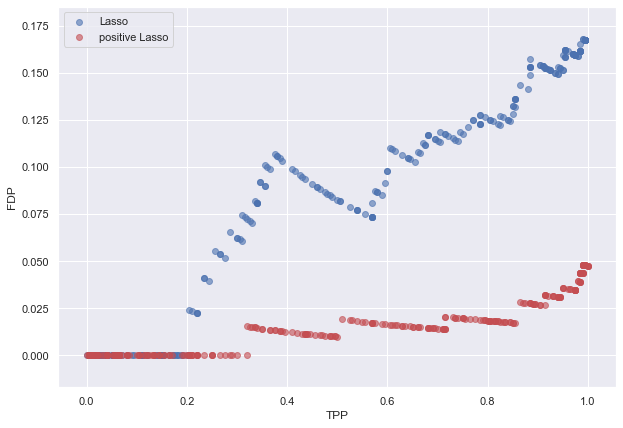

In [7]:
# select Lasso path to plot
TPP_list_lasso = TPP_lists[0]
FDP_list_lasso = FDP_lists[0]

# select positive Lasso path to plot
TPP_list_pos_lasso = TPP_lists_pos[0]
FDP_list_pos_lasso = FDP_lists_pos[0]

# selection first TPP index where equals to 1
id_sup_lasso = np.min(np.where(TPP_list_lasso >= 1)) 
id_sup_pos_lasso = np.min(np.where(TPP_list_pos_lasso >= 1)) 
id_sup = np.max([id_sup_lasso, id_sup_pos_lasso])
print("index sup: ", id_sup)

# plot
plt.figure(figsize=(10,7))
plt.scatter(TPP_list_lasso[:id_sup], FDP_list_lasso[:id_sup], color='b', label='Lasso', alpha=0.6)
plt.scatter(TPP_list_pos_lasso[:id_sup], FDP_list_pos_lasso[:id_sup], color='r', label='positive Lasso', alpha=0.6)
plt.xlabel('TPP')
plt.ylabel('FDP')
#plt.title('TPP and FDP along the (positive) Lasso path')
plt.legend(loc='best')
plt.show()

## TPP at first false selection & FDP at time of last true selection

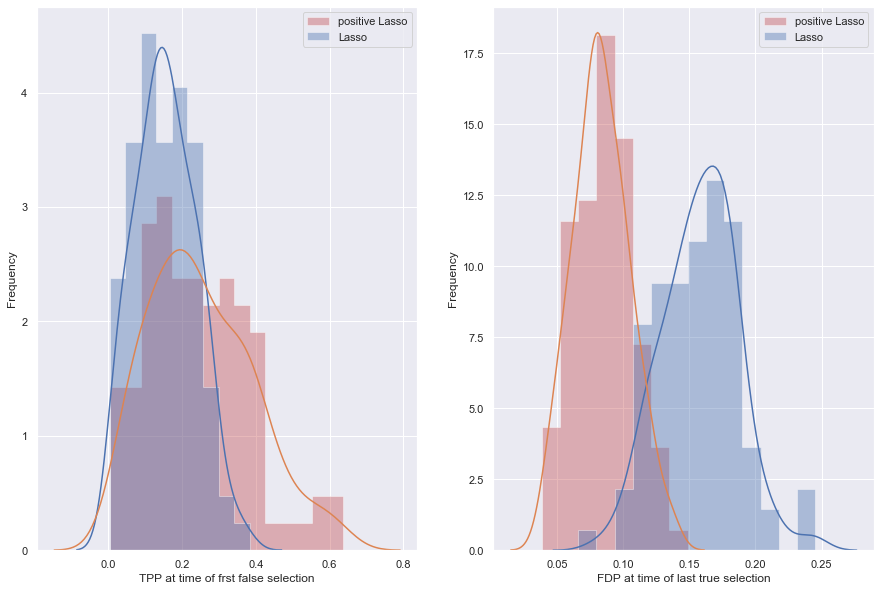

In [8]:
# plot TPP at first false selection & FDP at time of last true selection
plt.figure(figsize=(15,10))

plt.subplot(1, 2, 1)
plt.hist([TPP_first_FP[:100], TPP_first_FP_pos[:100]], density=True,
         bins=15, histtype='stepfilled', alpha=0.4,
         color=['b', 'r'], label=['Lasso', 'positive Lasso'])
sns.kdeplot(TPP_first_FP) # Kernel Density Estimation
sns.kdeplot(TPP_first_FP_pos) # Kernel Density Estimation
plt.xlabel('TPP at time of frst false selection')
plt.ylabel('Frequency')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.hist([FDP_last_TP[:100], FDP_last_TP_pos[:100]], density=True,
         bins=15, histtype='stepfilled', alpha=0.4,
         color=['b', 'r'], label=['Lasso', 'positive Lasso'])
sns.kdeplot(FDP_last_TP) # Kernel Density Estimation
sns.kdeplot(FDP_last_TP_pos) # Kernel Density Estimation
plt.xlabel('FDP at time of last true selection')
plt.ylabel('Frequency')
plt.legend(loc='best')

plt.axis('tight')
plt.show()

## Boundary curve q*

In [9]:
# =======================================================================
# Import the Python adaptation of the MatLab code
# that computes the Lasso path boundary.
# Python code available at :
# https://github.com/CedricAllainEnsae/fdrlasso/blob/master/fdrlasso.py
# Original MatLab code available at :
# https://github.com/wjsu/fdrlasso/blob/master/fdrlasso.m
# Copyright @ Weijie Su, Malgorzata Bogdan, and Emmanuel Candes, 2015
# =======================================================================

import sys
sys.path.insert(0,"./")
from fdrlasso import fdrlasso

In [10]:
# Compute the boundary curve for two values of delta
y_1 = [fdrlasso(tpp=x, delta=0.5, epsi=0.15) for x in np.linspace(0,1, num=100)]
y_2 = [fdrlasso(tpp=x, delta=0.3, epsi=0.15) for x in np.linspace(0,1, num=100)]

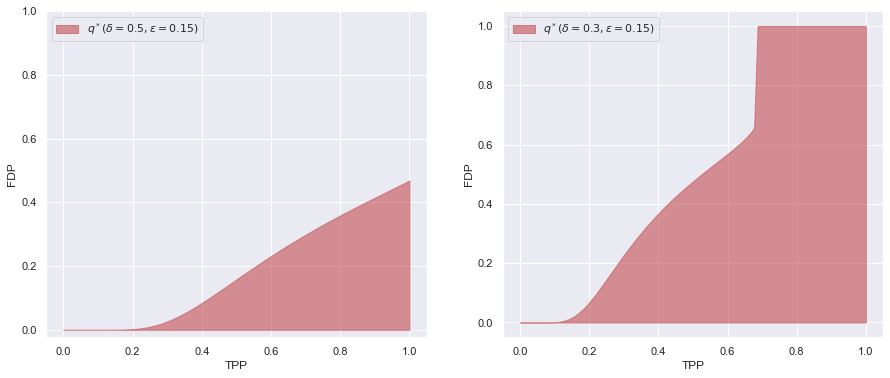

In [11]:
# plot the two boundary curves
plt.figure(figsize=(15,6))
x = np.linspace(0,1, num=100)

plt.subplot(1, 2, 1)
plt.fill_between(x, y_1, label='$q^*(\delta=0.5, \epsilon=0.15)$',
                 color='r', alpha=0.6)
plt.ylim(top=1)
plt.xlabel('TPP')
plt.ylabel('FDP')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.fill_between(x, y_2, label='$q^*(\delta=0.3, \epsilon=0.15)$',
                 color='r', alpha=0.6)
plt.ylim(top=1)
plt.xlabel('TPP')
plt.ylabel('FDP')
plt.legend(loc='upper left')

plt.axis('tight')
plt.show()

## The boundary function with different values of $\delta$ and $\epsilon$


In [12]:
# initialisation of dictionnary for all the Lasso boundaries
dict_q = {}

# with delta = 1.5, for epsilon = 0.4, 0.2 and 0.1
delta = 1.5
for epsi in [0.4, 0.2, 0.1]:
  y = [fdrlasso(tpp=x, delta=delta, epsi=epsi) for x in np.linspace(0,1, num=100)]
  dict_q['delta_'+str(delta)+'_epsi_'+str(epsi)] = y

# with delta = 1.5, for epsilon = 0.07, 0.05 and 0.03
delta = 1.5
for epsi in [0.07, 0.05, 0.03]:
  y = [fdrlasso(tpp=x, delta=delta, epsi=epsi) for x in np.linspace(0,1, num=100)]
  dict_q['delta_'+str(delta)+'_epsi_'+str(epsi)] = y

# with epsilon = 0.2, for delta = 1, 1.4 and 1.8
epsi = 0.2
for delta in [1, 1.4, 1.8]:
  y = [fdrlasso(tpp=x, delta=delta, epsi=epsi) for x in np.linspace(0,1, num=100)]
  dict_q['delta_'+str(delta)+'_epsi_'+str(epsi)] = y

# with epsilon = 0.05, for delta = 1, 1.4 and 1.8
epsi = 0.05
for delta in [1, 1.4, 1.8]:
  y = [fdrlasso(tpp=x, delta=delta, epsi=epsi) for x in np.linspace(0,1, num=100)]
  dict_q['delta_'+str(delta)+'_epsi_'+str(epsi)] = y

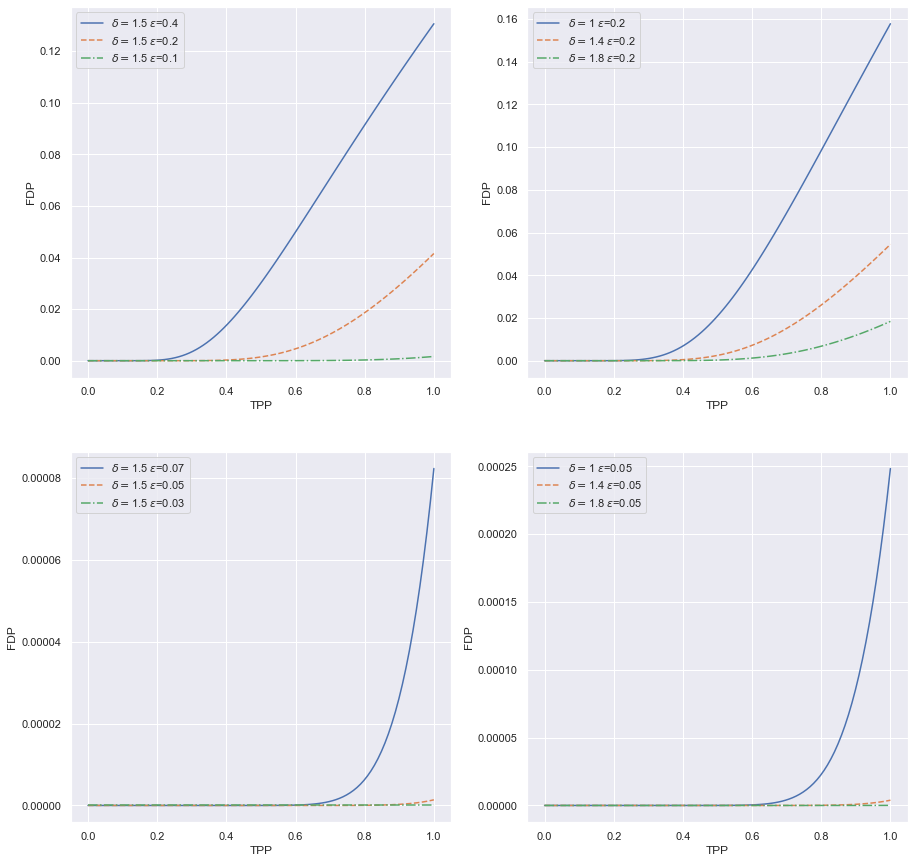

In [13]:
x = np.linspace(0,1, num=100)
line_types = cycle(['-', '--', '-.'])

fig, ax = plt.subplots(2, 2, figsize=(15,15))

delta = 1.5
for epsi, line_type in zip([0.4, 0.2, 0.1], line_types):
  y = dict_q['delta_'+str(delta)+'_epsi_'+str(epsi)]
  label = '$\delta=$' + str(delta) + ' $\epsilon$=' + str(epsi)
  ax[0,0].plot(x, y, line_type, label=label)
  #ax[0,0].set_ylim(top=1)
  ax[0,0].set_xlabel('TPP')
  ax[0,0].set_ylabel('FDP')
  ax[0,0].legend(loc='upper left')

delta = 1.5
for epsi, line_type in zip([0.07, 0.05, 0.03], line_types):
  y = dict_q['delta_'+str(delta)+'_epsi_'+str(epsi)]
  label = '$\delta=$' + str(delta) + ' $\epsilon$=' + str(epsi)
  ax[1,0].plot(x, y, line_type, label=label)
  #ax[1,0].set_ylim(top=1)
  ax[1,0].set_xlabel('TPP')
  ax[1,0].set_ylabel('FDP')
  ax[1,0].legend(loc='upper left')

epsi = 0.2
for delta, line_type in zip([1, 1.4, 1.8], line_types):
  y = dict_q['delta_'+str(delta)+'_epsi_'+str(epsi)]
  label = '$\delta=$' + str(delta) + ' $\epsilon$=' + str(epsi)
  ax[0,1].plot(x, y, line_type, label=label)
  #ax[0,1].set_ylim(top=1)
  ax[0,1].set_xlabel('TPP')
  ax[0,1].set_ylabel('FDP')
  ax[0,1].legend(loc='upper left')

epsi = 0.05
for delta, line_type in zip([1, 1.4, 1.8], line_types):
  y = dict_q['delta_'+str(delta)+'_epsi_'+str(epsi)]
  label = '$\delta=$' + str(delta) + ' $\epsilon$=' + str(epsi)
  ax[1,1].plot(x, y, line_type, label=label)
  #ax[1,1].set_ylim(top=1)
  ax[1,1].set_xlabel('TPP')
  ax[1,1].set_ylabel('FDP')
  ax[1,1].legend(loc='upper left')

plt.show()

# Existence of a positive Lasso path boundary

In this section, we try to show empirically the existence of a boundary for the positive Lasso path.

In [14]:
# n=p=1000, with noise (sigma_noise=1)
res_1000_noise = compute_lasso_path(n_exp=10, p=1000, delta=1, epsilon=0.2,
                                    M=50, sigma_data=1, sigma_noise=1,
                                    positive=True)

# n=p=5000, with noise (sigma_noise=1)
res_5000_noise = compute_lasso_path(n_exp=10, p=5000, delta=1, epsilon=0.2,
                                    M=50, sigma_data=1, sigma_noise=1,
                                    positive=True)

# n=p=1000, noiseless (sigma_noise=0)
res_1000_noiseless = compute_lasso_path(n_exp=10, p=1000, delta=1, epsilon=0.2,
                                        M=50, sigma_data=1, sigma_noise=0,
                                        positive=True)

# n=p=5000, noiseless (sigma_noise=0)
res_5000_noiseless = compute_lasso_path(n_exp=10, p=5000, delta=1, epsilon=0.2,
                                        M=50, sigma_data=1, sigma_noise=0,
                                        positive=True)

100%|██████████| 10/10 [42:53<00:00, 257.36s/it]


In [15]:
# transform results into DataFrames
dict_res_df = {}
for res, name in zip([res_1000_noise, res_5000_noise, res_1000_noiseless, res_5000_noiseless],
                     ['res_1000_noise', 'res_5000_noise', 'res_1000_noiseless', 'res_5000_noiseless']):
  # extract lists from results
  TPP_lists, FDP_lists, TPP_first_FP, FDP_last_TP = res
  # flatten lists
  TPP_lists_flatten = np.array(TPP_lists).flatten()
  FDP_lists_flatten = np.array(FDP_lists).flatten()
  # stocks into a Data Frame
  res_df = pd.DataFrame(data={'TPP': TPP_lists_flatten,
                              'FDP': FDP_lists_flatten})
  # sort by TPP value
  dict_res_df[name] = res_df.sort_values(by=['TPP'])

In [16]:
# compute the usual Lasso path boundary
x = np.linspace(0,1, num=100)
y = [fdrlasso(tpp=x, delta=1, epsi=0.2) for x in np.linspace(0,1, num=100)]
label_q = '$q^*(\delta=1, \epsilon=0.2)$'

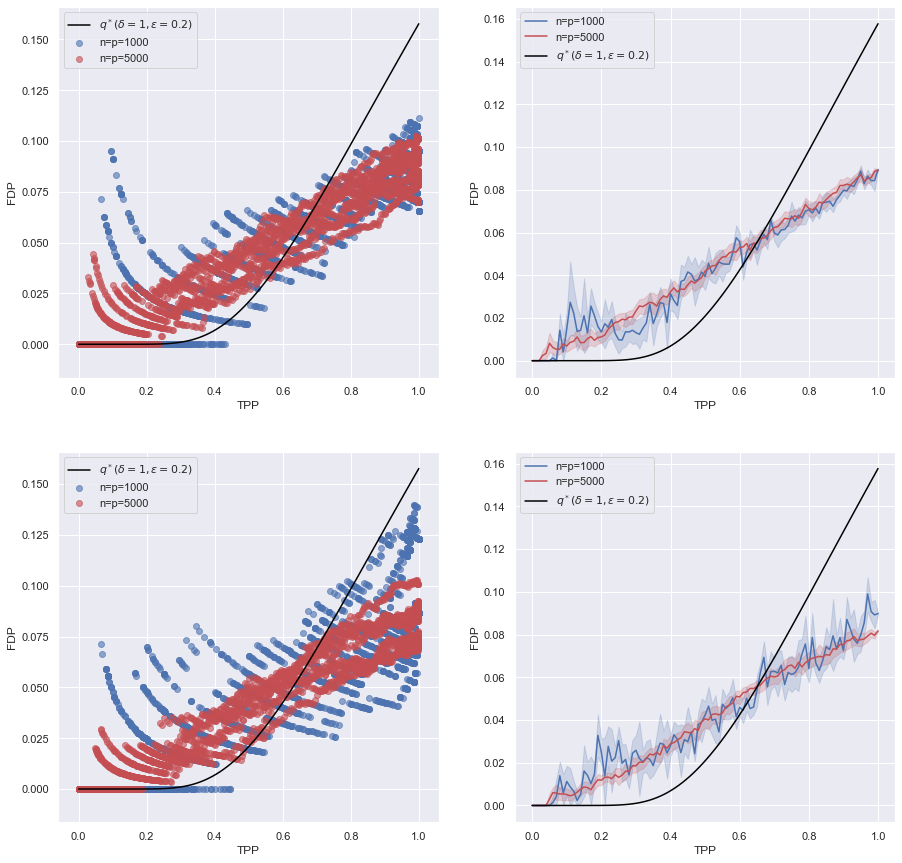

CPU times: user 19.3 s, sys: 280 ms, total: 19.5 s
Wall time: 21.2 s


In [17]:
%%time

n_decimals = 2 # number of decimal to keep when TPP values are rounded

# plot results
fig, ax = plt.subplots(2, 2, figsize=(15,15))

# with noise
res_df_1000 = dict_res_df['res_1000_noise'].copy()
res_df_5000 = dict_res_df['res_5000_noise'].copy()

id_sup_1000 = np.min(np.where(res_df_1000['TPP'] >= 1))
id_sup_5000 = np.min(np.where(res_df_5000['TPP'] >= 1))
id_sup = np.max([id_sup_1000, id_sup_5000])

ax[0,0].scatter(res_df_1000['TPP'][:id_sup], res_df_1000['FDP'][:id_sup],
                color='b', label='n=p=1000', alpha=0.6)
ax[0,0].scatter(res_df_5000['TPP'][:id_sup], res_df_5000['FDP'][:id_sup],
                color='r', label='n=p=5000', alpha=0.6)
ax[0,0].plot(x, y, '-', color='black', label=label_q)
ax[0,0].set_xlabel('TPP')
ax[0,0].set_ylabel('FDP')
ax[0,0].legend(loc='upper left')

res_df_1000['TPP'] = res_df_1000['TPP'].apply(lambda x: np.round(x, n_decimals))
sns.lineplot(x="TPP", y="FDP", data=res_df_1000,
             color='b', label='n=p=1000', ax=ax[0,1])#, err_style="bars")
res_df_5000['TPP'] = res_df_5000['TPP'].apply(lambda x: np.round(x, n_decimals))
sns.lineplot(x="TPP", y="FDP", data=res_df_5000,
             color='r', label='n=p=5000', ax=ax[0,1])#, err_style="bars")
ax[0,1].plot(x, y, '-', color='black', label=label_q)
ax[0,1].set_xlabel('TPP')
ax[0,1].set_ylabel('FDP')
ax[0,1].legend(loc='upper left')

# noiseless
res_df_1000 = dict_res_df['res_1000_noiseless'].copy()
res_df_5000 = dict_res_df['res_5000_noiseless'].copy()

id_sup_1000 = np.min(np.where(res_df_1000['TPP'] >= 1))
id_sup_5000 = np.min(np.where(res_df_5000['TPP'] >= 1))
id_sup = np.max([id_sup_1000, id_sup_5000])

ax[1,0].scatter(res_df_1000['TPP'][:id_sup], res_df_1000['FDP'][:id_sup],
                color='b', label='n=p=1000', alpha=0.6)
ax[1,0].scatter(res_df_5000['TPP'][:id_sup], res_df_5000['FDP'][:id_sup],
                color='r', label='n=p=5000', alpha=0.6)
ax[1,0].plot(x, y, '-', color='black', label=label_q)
ax[1,0].set_xlabel('TPP')
ax[1,0].set_ylabel('FDP')
ax[1,0].legend(loc='upper left')

res_df_1000['TPP'] = res_df_1000['TPP'].apply(lambda x: np.round(x,n_decimals))
sns.lineplot(x="TPP", y="FDP", data=res_df_1000,
             color='b', label='n=p=1000', ax=ax[1,1])#, err_style="bars")
res_df_5000['TPP'] = res_df_5000['TPP'].apply(lambda x: np.round(x,n_decimals))
sns.lineplot(x="TPP", y="FDP", data=res_df_5000,
             color='r', label='n=p=5000', ax=ax[1,1])#, err_style="bars")
ax[1,1].plot(x, y, '-', color='black', label=label_q)
ax[1,1].set_xlabel('TPP')
ax[1,1].set_ylabel('FDP')
ax[1,1].legend(loc='upper left')

plt.show()

# Rank of first false discovery as a function of the sparsity

In [57]:
k_min = 5
k_max = 150

list_TPP_first_FP = []
list_FDP_last_TP = []

p = 1000
delta = 1

for k in range(k_min, k_max+1, 5):
  res = compute_lasso_path(n_exp=100, p=p, delta=delta, epsilon=k, M=50,
                           sigma_data=1, sigma_noise=1, positive=True)
  _, _, TPP_first_FP, FDP_last_TP = res

  list_TPP_first_FP.append(TPP_first_FP)
  list_FDP_last_TP.append(FDP_last_TP)

100%|██████████| 100/100 [11:13<00:00,  6.73s/it]


In [58]:
list_ranks_first_FD = []
for TPP_first_FP, k in zip(list_TPP_first_FP, range(k_min, k_max+1, 5)):
  ranks_first_FD = [int(tpp*k) for tpp in TPP_first_FP]
  list_ranks_first_FD.append(ranks_first_FD)

In [59]:
x = np.array(list_ranks_first_FD).T
# compute for each value of k the mean, min and max
mins = x.min(0)
maxes = x.max(0)
means = x.mean(0)
std = x.std(0)
q1, med, q3 = np.quantile(x, [0.25, 0.5, 0.75], axis=0)

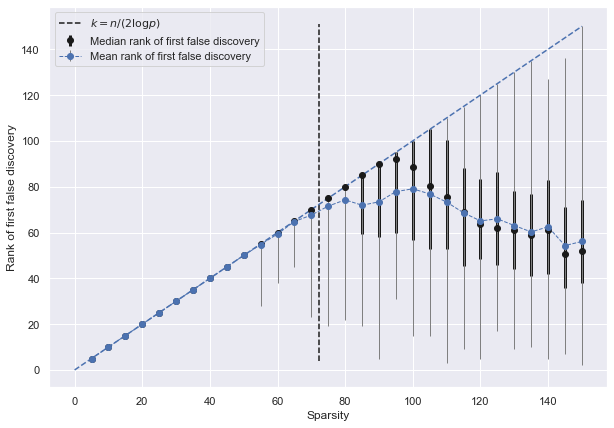

In [81]:
plt.figure(figsize=(10,7))
#plt.errorbar(np.arange(k_min, k_max+1, 5), means, std, fmt='ok', lw=3)
plt.errorbar(np.arange(k_min, k_max+1, 5), med, [med - q1, q3 - med],
             fmt='ok', lw=3, label='Median rank of first false discovery')
plt.errorbar(np.arange(k_min, k_max+1, 5), means, [means - mins, maxes - means],
             fmt='--o', ecolor='gray', lw=1,label='Mean rank of first false discovery')
plt.plot(np.linspace(0,k_max), np.linspace(0,k_max), '--')
x_tick = p*delta/(2*np.log(p))
plt.vlines(x_tick, ymin=k_min-1, ymax=k_max+1, linestyles='--', label='$k=n/(2\log p)$')
plt.xlabel('Sparsity')
plt.ylabel('Rank of first false discovery')
plt.legend(loc='upper left')
plt.show()